# new summarizer

# Program Setup

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from transformers import BartForConditionalGeneration, BartTokenizer

# this is for python rich output
console = Console()

/Users/dallasgere/dev/news_summarizer/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Getting the data

In [4]:
df = pd.read_csv("../data/cnn_dailymail/train.csv")

# Exploratory Data Analysis

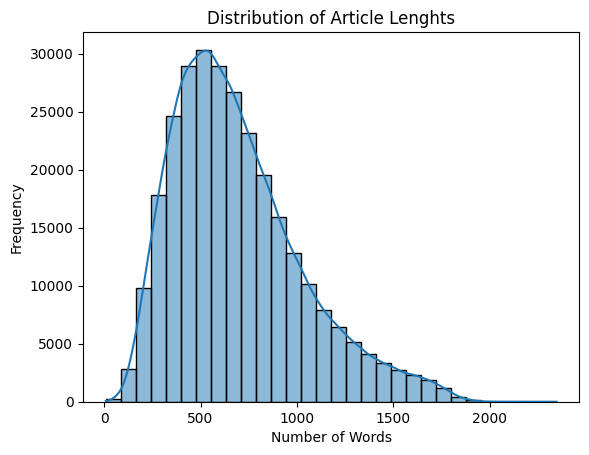

In [4]:
"""
plotting distribution of article lengths
"""

sns.histplot(df["article"].str.split().str.len(), bins=30, kde=True)
plt.title("Distribution of Article Lenghts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

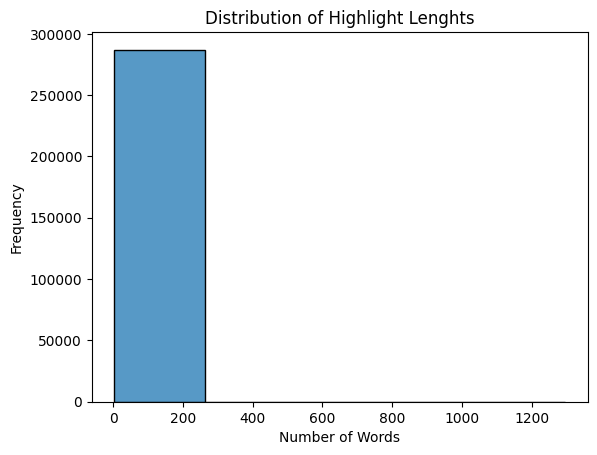

In [5]:
"""
plotting the highlight lenghts
"""

# sns.histplot(df["highlights"].str.split().str.len(), bins=5, kde=True)
sns.histplot(df["highlights"].str.split().str.len(), bins=5)
plt.title("Distribution of Highlight Lenghts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

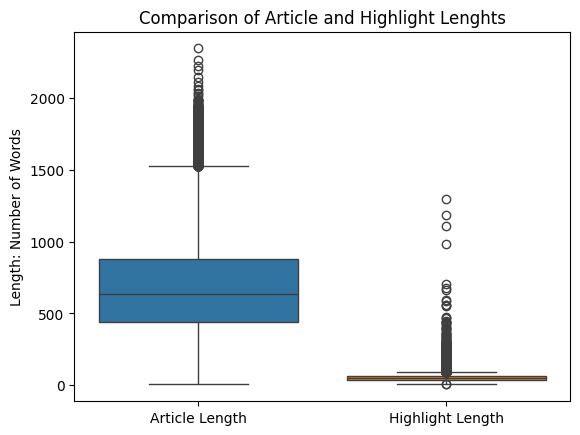

In [5]:
"""
compare lengths of articles and highlights
"""

lenghts = pd.DataFrame({
    "Article Length": df["article"].str.split().str.len(),
    "Highlight Length": df["highlights"].str.split().str.len(),
})

sns.boxplot(data=lenghts)
plt.title("Comparison of Article and Highlight Lenghts")
plt.ylabel("Length: Number of Words")
plt.show()

# Preprocessing With Pandas

In [6]:
def remove_non_alphanumeric(text: str) -> str:
    """Removing all non alphanumeric characters.

    This function is slow so may not be recommended

    Args:
        text (str): string to remove non alphanumeric characters from

    Returns:
        str: new string
    """
    return "".join([char for char in text if char.isalnum or char.isspace])

In [7]:
"""
Removing non alphanumeric characters from articles and highlights.
"""

# this method took 1 min 8 seconds
# df["article"] = df["article"].apply(remove_non_alphanumeric)
# df["highlights"] = df["highlights"].apply(remove_non_alphanumeric)

# this took 12.6 seconds, definitely use this
df["article"] = df["article"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
df["highlights"] = df["highlights"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)

In [8]:
"""
getting quick glimpse at the data
"""

df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By Associated Press PUBLISHED 1411 EST 25 O...,Bishop John Folda of North Dakota is taking ti...
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,CNN Ralph Mata was an internal affairs lieute...,Criminal complaint Cop used his role to help c...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,Craig EcclestonTodd 27 had drunk at least thre...
3,0002c17436637c4fe1837c935c04de47adb18e9a,CNN With a breezy sweep of his pen President ...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 20 win at Sc...


In [9]:
"""
making all characters lower case in articles and highlights
"""

# this only took 2.3 seconds so idk how they made these dataframes so fast but its pretty awesome
df["article"] = df["article"].str.lower()
df["highlights"] = df["highlights"].str.lower()

In [10]:
"""
getting quick glimpse at the data

article and highlights should be lowercase at this point
"""

df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,by associated press published 1411 est 25 o...,bishop john folda of north dakota is taking ti...
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,cnn ralph mata was an internal affairs lieute...,criminal complaint cop used his role to help c...
2,00027e965c8264c35cc1bc55556db388da82b07f,a drunk driver who killed a young woman in a h...,craig ecclestontodd 27 had drunk at least thre...
3,0002c17436637c4fe1837c935c04de47adb18e9a,cnn with a breezy sweep of his pen president ...,nina dos santos says europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,fleetwood are the only team still to have a 10...,fleetwood top of league one after 20 win at sc...


In [11]:
"""
article will be the input, the output will be the highlights
"""

# using the tolist function to achieve this
input_text_list = df["article"].tolist()
output_text_list = df["highlights"].tolist()

# this needs to be True or else its not good
print(f"intput output lenghts equal: {len(input_text_list) == len(output_text_list)}")

# turning it into one list
input_output_text = list(zip(input_text_list, output_text_list))

# printing more readable with rich
for i, (input, output) in enumerate(input_output_text[:5], 1):
    input_text = Text(input[:100] + "..." if len(input) > 100 else input)
    input_text.stylize("bold magenta")
    
    output_text = Text(output[:100] + "..." if len(output) > 100 else output)
    output_text.stylize("bold cyan")
    
    panel = Panel(
        Text.assemble(
            ("Input: ", "bold green"),
            input_text,
            "\n\n",
            ("Output: ", "bold yellow"),
            output_text
        ),
        title=f"Example {i}",
        expand=False,
        border_style="bold blue"
    )
    
    console.print(panel)
    console.print()

intput output lenghts equal: True


╭────────────────────────────────────────────────── Example 1 ───────────────────────────────────────────────────╮
│ Input: by  associated press  published  1411 est 25 october 2013    updated  1536 est 25 october 2013  the ... │
│                                                                                                                │
│ Output: bishop john folda of north dakota is taking time off after being diagnosed                             │
│ he contracted the infect...                                                                                    │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Example 2 ───────────────────────────────────────────────────╮
│ Input: cnn  ralph mata was an internal affairs lieutenant for the miamidade police department working in th... │
│                                                                                                                │
│ Output: criminal complaint cop used his role to help cocaine traffickers                                       │
│ ralph mata an internal affairs lie...                                                                          │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Example 3 ───────────────────────────────────────────────────╮
│ Input: a drunk driver who killed a young woman in a headon crash while checking his mobile phone has been j... │
│                                                                                                                │
│ Output: craig ecclestontodd 27 had drunk at least three pints before driving car                               │
│ was using phone when he ve...                                                                                  │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Example 4 ───────────────────────────────────────────────────╮
│ Input: cnn  with a breezy sweep of his pen president vladimir putin wrote a new chapter into crimeas turbul... │
│                                                                                                                │
│ Output: nina dos santos says europe must be ready to accept sanctions will hurt both sides                     │
│ targeting russia...                                                                                            │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Example 5 ───────────────────────────────────────────────────╮
│ Input: fleetwood are the only team still to have a 100 record in sky bet league one as a 20 win over scunth... │
│                                                                                                                │
│ Output: fleetwood top of league one after 20 win at scunthorpe                                                 │
│ peterborough bristol city chesterfield and c...                                                                │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# Training BART Model

In [ ]:
"""
getting the model and tokenizer from BART
"""

# this should take around 2 minutes the first time but for some reason the second time I ran it it was 8 seconds
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")